In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
from tqdm import tqdm
import gc
import pickle
import random
from pathlib import Path
import re
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed(seed=2020)

from IPython.display import display, HTML
js = """<script>IPython.notebook.kernel.execute("file_name=('" + IPython.notebook.notebook_name + "')");</script>"""
display(HTML(js))

In [20]:
class CFG:
    VER = 1
    EXP_NAME = file_name.split('.')[0]
    AUTHOR = 'endo'
    METHOD = 'lightgbm'
    COMPETITION = 'ocean180'
    DATA_PATH = Path('../data') # データへのpathを設定
    SAVE_FOLDER = Path('save_folder1')
    MODEL_PATH = SAVE_FOLDER / 'models'
    FEATURE_PATH = SAVE_FOLDER / 'features'
    OTHER_PATH = SAVE_FOLDER / 'others'

    target_col = 'cover'
    num_fold = 7
    seed = 0
    
    '''
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': 'gbdt',
        'seed': seed,
    }'''
    
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'seed': seed,
        "force_col_wise":True,
        
        'num_leaves': 13, 
        'learning_rate': 0.1, 
        'max_depth': 3, 
        'min_data_in_leaf': 18, 
        'feature_fraction': 0.8451467012467969, 
        'bagging_fraction': 0.6325478395413221, 
        'lambda_l1': 0.8818965030968323, 
        'lambda_l2': 0.7196201578422882, 
        'extra_trees': True,
        # 'drop_rate': 0.9,
    }

In [21]:
int(3/2)

1

In [22]:
int(5/2)

2

In [23]:
int(7/2)

3

## Preprocessing

In [24]:
def preprocessing(input_df: pd.DataFrame, train_mode=False)->pd.DataFrame:
    print('feature processing start...')
    output_df = input_df.copy()
    
    # Feature engineering with original data
    output_df['year'] = output_df['year'].astype(int)
    output_df['grid_20m'] = ((output_df['lon']-122)/(1/4550)*100000 + (output_df['lat']-24)/(1/4500)).astype(int)

    # Conversion based on base year

    year_columns_patterns = [col.replace(re.findall("2010", col)[0], "") for col in output_df.columns if re.findall("2010", col)]
    year_columns = [col for col in output_df.columns if re.findall("20\d{2}", col)]
    year_lag_dict = {}
    LAG_NUM = 7
    lags = [i-int(LAG_NUM/2) for i in range(LAG_NUM)]
    for i in range(22):# 0>20
        year = 1999 + i
        year_lag_dict[year] = {}
        for lag in lags:#7, 5
            lagged_year = year + lag
            if (2000<=lagged_year) and (lagged_year<=2020):
                for c in year_columns_patterns:
                    key = f'{c}{lagged_year}'
                    year_lag_dict[year][key] = f'{c}{lag}'
    
    def extract_rename(row):
        year = row['year']
        return row[list(year_lag_dict[year].keys())].rename(year_lag_dict[year])
    main_df = output_df.drop(year_columns, axis=1)
    print(main_df.shape)
    yearly_df = output_df.apply(extract_rename, axis=1)
    output_df = pd.concat([main_df, yearly_df], axis=1)
    
    # pca
    if train_mode:
        pca = PCA(n_components=12)
        # yearly_df.fillna(-99999, inplace=True)
        pca.fit(main_df.drop([CFG.target_col, 'grid_20m', 'mesh20'], axis=1).fillna(-99999))
        main_pca = pd.DataFrame(pca.transform(main_df.drop([CFG.target_col, 'grid_20m', 'mesh20'], axis=1).fillna(-99999))).add_suffix('_main')
        with open(CFG.FEATURE_PATH / 'pca_model_main.pkl', 'wb') as f:
            pickle.dump(pca, f)
    else:
        with open(CFG.FEATURE_PATH / 'pca_model_main.pkl', 'rb') as f:
            pca = pickle.load(f)
        main_pca = pd.DataFrame(pca.transform(main_df.drop(['grid_20m', 'mesh20'], axis=1).fillna(-99999))).add_suffix('_main')
    
    # pca
    if train_mode:
        pca = PCA(n_components=12)
        # yearly_df.fillna(-99999, inplace=True)
        pca.fit(yearly_df.fillna(-99999))
        yearly_pca = pd.DataFrame(pca.transform(yearly_df.fillna(-99999))).add_suffix('_yearly')
        with open(CFG.FEATURE_PATH / 'pca_model_yearly.pkl', 'wb') as f:
            pickle.dump(pca, f)
    else:
        with open(CFG.FEATURE_PATH / 'pca_model_yearly.pkl', 'rb') as f:
            pca = pickle.load(f)
        yearly_pca = pd.DataFrame(pca.transform(yearly_df.fillna(-99999))).add_suffix('_yearly')
    print(f'PCA: {yearly_df.shape} > {yearly_pca.shape}')
    output_df = pd.concat([output_df, yearly_pca], axis=1)
    
    # moving average etc.: Incorporate information on annual fluctuations
    med_patterns = [col.replace(re.findall("-1", col)[0], "") for col in output_df.columns if re.findall("-1", col) and re.findall("MED", col)]
    new_cols = pd.DataFrame()
    for c in med_patterns:
        # print(f'---------------- {c} ---------------------')
        cs = [f'{c}{lag}' for lag in lags] # cs = [col for col in output_df.columns if re.findall(c, col)]
        cs = sorted(cs, key=lambda x: int(x.split('_')[-1]))
        temp_df = output_df[cs].T
        window = 3
        rolling_mean = temp_df.rolling(window=window, min_periods=1).mean().T.add_suffix(f'_mv{window}')
        # print(rolling_mean.columns)
        difference = temp_df.diff().T.add_suffix(f'_diff')
        new_cols = pd.concat([new_cols, rolling_mean], axis=1)
        new_cols = pd.concat([new_cols, difference], axis=1)
    output_df = pd.concat([output_df, new_cols], axis=1)
    
    # pca
    if train_mode:
        pca = PCA(n_components=12)
        # yearly_df.fillna(-99999, inplace=True)
        pca.fit(new_cols.fillna(-99999))
        new_cols_pca = pd.DataFrame(pca.transform(new_cols.fillna(-99999))).add_suffix('_new_cols')
        with open(CFG.FEATURE_PATH / 'pca_model_new_cols.pkl', 'wb') as f:
            pickle.dump(pca, f)
    else:
        with open(CFG.FEATURE_PATH / 'pca_model_new_cols.pkl', 'rb') as f:
            pca = pickle.load(f)
        new_cols_pca = pd.DataFrame(pca.transform(new_cols.fillna(-99999))).add_suffix('_new_cols')
    print(f'PCA: {new_cols.shape} > {new_cols_pca.shape}')
    ### output_df = pd.concat([output_df, new_cols_pca], axis=1)
    
    # concat all pca as output_df
    if train_mode:
        output_df = output_df[[CFG.target_col, 'grid_20m', 'mesh20']] 
    else:
        output_df = output_df[['grid_20m', 'mesh20']] 
    output_df = pd.concat([output_df, main_pca], axis=1)
    output_df = pd.concat([output_df, yearly_pca], axis=1)
    output_df = pd.concat([output_df, new_cols_pca], axis=1)

    # Processes missing-value
    output_df.fillna(-99999, inplace=True)

    '''
    if train_mode:
        le_dict = {}
        for c in output_df.select_dtypes(include=['object']).columns.to_list():
            le = LabelEncoder()
            print(c)
            le.fit(output_df[c])
            output_df[c] = le.transform(output_df[c])
            le_dict[c] = le
        with open(CFG.FEATURE_PATH / 'le_dict.pkl', "wb") as f:# only training
            pickle.dump(le_dict, f)# only training
    else:
        with open(CFG.FEATURE_PATH / 'le_dict.pkl', 'rb') as f:
            le = pickle.load(f)
        print(le)
        le_keys = list(le.keys())
        for c in le_keys:
            output_df[c] = le[c].transform(output_df[c])'''

    print(f'Shape: {input_df.shape} >> {output_df.shape}')
    return output_df

def get_train_data()->pd.DataFrame:
    # id, ymd>>書式が多すぎて統一できない, Landsat_StartTime, PRODUCT_ID
    df = pd.read_csv(CFG.DATA_PATH / 'train_data.csv').drop(['Unnamed: 0', 'YMD', 'Landsat_StartTime', 'PRODUCT_ID'], axis=1)
    return preprocessing(df, train_mode=True)

def get_test_data():
    df = pd.read_csv(CFG.DATA_PATH / 'test_data.csv').drop(['Unnamed: 0', 'YMD', 'Landsat_StartTime', 'PRODUCT_ID'], axis=1)
    return preprocessing(df)

## Learning

In [25]:
def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_randomkfold(train, target_col, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def lgb_training(train, features):
    CFG.folds = get_groupkfold(train, CFG.target_col, 'mesh20', CFG.num_fold)
    # CFG.folds = get_randomkfold(train, CFG.target_col, CFG.num_fold)
    CFG.folds.to_csv(CFG.OTHER_PATH/'folds.csv', index=False)
    oof_pred = np.zeros(len(train), dtype=np.float64)
    df_importance = pd.DataFrame({'feature': features})
    df_importance['importance'] = 0
    models = []#
    for fold in range(CFG.num_fold):
        # print(f'\n--------------- {fold} --------------')
        idx_train = CFG.folds!=fold
        idx_valid = CFG.folds==fold
        x_train = train[idx_train][features]
        y_train = train[idx_train][CFG.target_col]
        x_valid = train[idx_valid][features]
        y_valid = train[idx_valid][CFG.target_col]
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)
        model = lgb.train(
            params = CFG.lgb_params,
            train_set = lgb_train,
            num_boost_round = 100000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 500,
            verbose_eval=50,
        )
        model_path = f'{CFG.METHOD}_fold{fold}_seed{CFG.seed}_ver{CFG.VER}.pkl'
        pickle.dump(model, open(CFG.MODEL_PATH/model_path, 'wb'))
        oof_pred[idx_valid] = model.predict(x_valid)

        f_importance = np.array(model.feature_importance())
        temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
        df_importance['importance'] += temp_importance['importance']
        models.append(model)
    
    df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
    df_importance = df_importance.sort_values('importance', ascending=False)
    df_importance.to_csv(CFG.OTHER_PATH / f'{CFG.METHOD}_feature_importance_seed{CFG.seed}_ver{CFG.VER}.csv', header=True, index=False)
    # display(df_importance.head(50))
    score = np.sqrt(mean_squared_error(train[CFG.target_col], oof_pred))
    np.save(CFG.OTHER_PATH / f'oof_pred_{CFG.METHOD}_seed{CFG.seed}_ver{CFG.VER}', oof_pred)

    # ========================================
    # feature importance
    # ========================================
    def visualize_importance(models, feat_train_df):
        feature_importance_df = pd.DataFrame()
        #print('--')
        for i, model in enumerate(models):
            _df = pd.DataFrame()
            importance_type = 'split'
            _df["feature_importance"] = model.feature_importance(importance_type=importance_type)
            _df["column"] = feat_train_df.columns
            _df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df],
                                            axis=0, ignore_index=True)
            #print(feature_importance_df.shape)
        #print('--')
            
        order = feature_importance_df.groupby("column")\
            .sum()[["feature_importance"]]\
            .sort_values("feature_importance", ascending=False).index
        print('order: ', order[:50])

        feature_importance_df["column"] = pd.Categorical(feature_importance_df["column"], categories=order, ordered=True)
        feature_importance_df = feature_importance_df.sort_values(by="column", ascending=False)

        num_display = len(order)# 50
        # print(feature_importance_df[:num_display].shape)
        fig, ax = plt.subplots(figsize=(12, max(6, num_display * .25)))
        sns.boxplot(data=feature_importance_df,
                    x="feature_importance",
                    y="column",
                    order=order,
                    ax=ax,
                    palette="viridis",
                    orient="h")
        ax.tick_params(axis="x", rotation=90)
        ax.set_title("Importance")
        ax.grid()
        fig.tight_layout()
    visualize_importance(models, train[features])

    print(f'CV Score: {score}')
    
    return score

## Prediction

In [26]:
def lgb_Predicting(test, features):
    test_preds = np.zeros((len(test), CFG.num_fold))
    x_test = test[features]
    for fold in range(CFG.num_fold):
        model_path = f'{CFG.METHOD}_fold{fold}_seed{CFG.seed}_ver{CFG.VER}.pkl'
        model = pickle.load(open(CFG.MODEL_PATH / model_path, 'rb'))
        test_preds[:, fold] = model.predict(x_test)
    np.save( CFG.OTHER_PATH / f'oof_pred_{CFG.METHOD}_seed{CFG.seed}_ver{CFG.VER}', test_preds)
    pd.DataFrame(np.mean(test_preds, axis=1)).to_csv(CFG.SAVE_FOLDER / f'submit_{CFG.EXP_NAME}.csv', header=False)

## Main

In [27]:
train = get_train_data()
test = get_test_data()
features = list(train.drop([CFG.target_col, 'grid_20m', 'mesh20'], axis=1))
print('\n', train.shape, test.shape, len(features))

feature processing start...
(14140, 312)
PCA: (14140, 1050) > (14140, 12)
PCA: (14140, 700) > (14140, 12)
Shape: (14140, 3461) >> (14140, 39)
feature processing start...
(4039, 311)
PCA: (4039, 1050) > (4039, 12)
PCA: (4039, 700) > (4039, 12)
Shape: (4039, 3460) >> (4039, 38)

 (14140, 39) (4039, 38) 36


[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 36
[LightGBM] [Info] Start training from score 0.187630
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 0.181096	valid_1's rmse: 0.239655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	training's rmse: 0.137664	valid_1's rmse: 0.235235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	training's rmse: 0.136494	valid_1's rmse: 0.235477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	training's rmse: 0.135474	valid_1's rmse: 0.236274
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's rmse: 0.14417	valid_1's rmse: 0.289918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1100]	training's rmse: 0.129982	valid_1's rmse: 0.290436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	training's rmse: 0.129216	valid_1's rmse: 0.291192
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	training's rmse: 0.144162	valid_1's rmse: 0.154692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	training's rmse: 0.143132	valid_1's r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	training's rmse: 0.132534	valid_1's rmse: 0.152758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2200]	training's rmse: 0.125715	valid_1's rmse: 0.151952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2800]	training's rmse: 0.120801	valid_1's rmse: 0.151063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2850]	training's rmse: 0.120474	valid_1's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3450]	training's rmse: 0.116871	valid_1's rmse: 0.151069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	training's rmse: 0.138384	valid_1's rmse: 0.220199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's rmse: 0.156461	valid_1's rmse: 0.126846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 0.18081	valid_1's rmse: 0.249447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	training's rmse: 0.135858	valid_1's rmse: 0.237202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	training's rmse: 0.13469	valid_1's rmse: 0.236866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

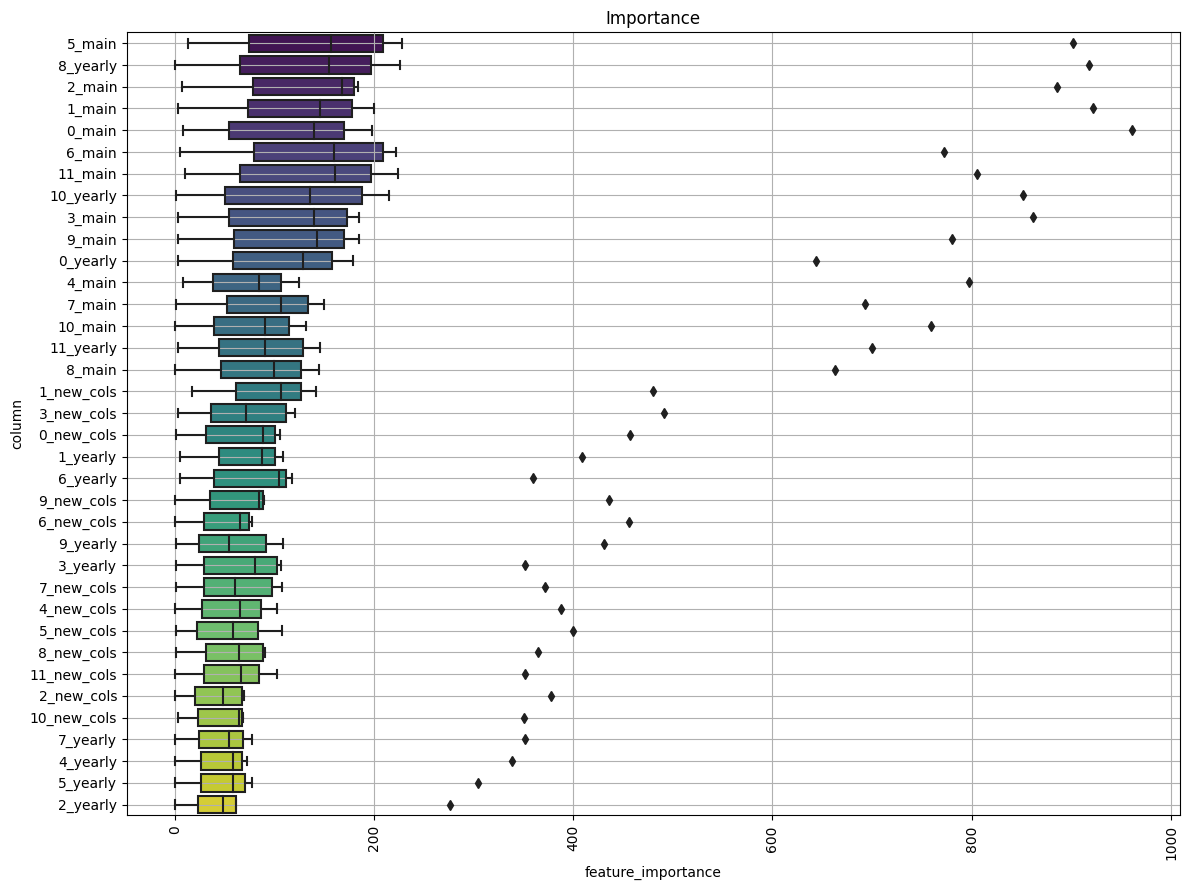

In [28]:
score = lgb_training(train, features)# -9999999

In [29]:
lgb_Predicting(test, features)